In [1]:
import numpy as np
import pandas as pd
import joblib
import time

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN,  RandomOverSampler 
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss, brier_score_loss, roc_auc_score, average_precision_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf 

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
df = pd.read_csv("../3 flood data analysis/output/Flood_Type_data.csv")
df.head()

,median_sea_level_height_msl_30,mean_sea_level_height_msl_30,mean_sea_level_height_msl_5,mean_sea_level_height_msl_1,max_sea_level_height_msl_1,lat,lon,Sea distance,Type,median_river_discharge_30,...,max_soil_moisture_28_to_100cm_1,max_soil_moisture_100_to_255cm_1,elevation,median_wave_height_30,mean_wave_height_30,mean_wave_height_5,mean_wave_height_1,max_wave_height_1,month,Type_cd
0,0.80470,0.802224,1.036652,0.958875,1.2597,41.324590,19.456469,5300.276600,River,0.383566,...,0.427,0.352,3.0,0.70,0.899865,1.667167,2.015833,3.14,11,2
1,0.81185,0.807646,0.982063,0.889192,1.1707,41.324590,19.456469,5300.276600,River,0.570363,...,0.428,0.360,3.0,0.74,0.923091,1.512000,1.275000,2.10,12,2
2,0.81370,0.813203,0.957242,0.940275,1.1667,41.324590,19.456469,5300.276600,River,0.625549,...,0.428,0.365,3.0,0.76,0.934274,1.224000,0.780833,1.22,12,2
3,0.82515,0.824850,0.991565,1.146608,1.4819,41.324590,19.456469,5300.276600,River,0.782379,...,0.422,0.368,3.0,0.78,0.961371,1.237667,1.142500,1.90,12,2
4,0.80470,0.802224,1.036652,0.958875,1.2597,41.786073,19.646076,11519.642694,River,0.428894,...,0.408,0.373,20.0,0.70,0.899865,1.667167,2.015833,3.14,11,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19860 entries, 0 to 19859
Data columns (total 82 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   median_sea_level_height_msl_30        19860 non-null  float64
 1   mean_sea_level_height_msl_30          19860 non-null  float64
 2   mean_sea_level_height_msl_5           19860 non-null  float64
 3   mean_sea_level_height_msl_1           19860 non-null  float64
 4   max_sea_level_height_msl_1            19860 non-null  float64
 5   lat                                   19860 non-null  float64
 6   lon                                   19860 non-null  float64
 7   Sea distance                          19860 non-null  float64
 8   Type                                  19860 non-null  object 
 9   median_river_discharge_30             19860 non-null  float64
 10  mean_river_discharge_30               19860 non-null  float64
 11  mean_river_disc

In [4]:

X = df.drop(["lat", "lon", "Type", "Type_cd"], axis=1)
y = df.loc[:,"Type_cd"] # predict flood type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

In [5]:
adasyn = ADASYN(random_state=24)
X_train_resampled_ada, y_train_resampled_ada = adasyn.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=24)
X_train_resampled_ros, y_train_resampled_ros = ros.fit_resample(X_train, y_train)

In [6]:
def get_LG_model() :
    model = Pipeline(steps=[
        ("standard_scaler", StandardScaler()),
        ("Classifier",LogisticRegression(max_iter=1000))
    ])
    return model

In [7]:
lg_model = get_LG_model()

In [8]:
lg_model.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('Classifier', LogisticRegression(max_iter=1000))])

In [9]:
def evaluate_model(y_pred, y_true, return_metrics=True):
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    report = classification_report(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Macro F1 Score:", f1_macro)
    print("Micro F1 Score:", f1_micro)
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    if return_metrics :
        return {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'classification_report': classification_report(y_true, y_pred, output_dict=True),
            'confusion_matrix': conf_matrix.tolist()
        }

In [10]:
y_pred = lg_model.predict(X_test)
print(f"Train score: {lg_model.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)

Train score: 0.9375
Accuracy: 0.93932527693857
Macro F1 Score: 0.5951655102190604
Micro F1 Score: 0.93932527693857

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.53      0.69        34
           1       0.69      0.16      0.26       210
           2       0.94      0.99      0.97      3684
           3       0.62      0.36      0.46        44

    accuracy                           0.94      3972
   macro avg       0.81      0.51      0.60      3972
weighted avg       0.93      0.94      0.92      3972

Confusion Matrix:
 [[  18    0   16    0]
 [   0   34  172    4]
 [   0   15 3663    6]
 [   0    0   28   16]]


In [11]:
def get_RF_model() :
    model = Pipeline(steps=[
        ("standard_scaler", StandardScaler()),
        ("Classifier",RandomForestClassifier(random_state=24))
    ])
    return model

In [12]:
def get_XGBC_model() :
    model = Pipeline(steps=[
        ("standard_scaler", StandardScaler()),
        ("Classifier",XGBClassifier(random_state=24))
    ])
    return model

In [13]:
def get_SVC_model() :
    model = Pipeline(steps=[
        ("standard_scaler", StandardScaler()),
        ("Classifier",SVC())
    ])
    return model

In [14]:
dataset_config = {
    "names": ["raw_data", "adasyn_oversampled", "random_oversampled"],
    "features": {
        "raw_data": X_train,
        "adasyn_oversampled": X_train_resampled_ada,
        "random_oversampled": X_train_resampled_ros
    },
    "labels": {
        "raw_data": y_train,
        "adasyn_oversampled": y_train_resampled_ada,
        "random_oversampled": y_train_resampled_ros
    }
}

model_config = {
    "classifier_names": [
        "logistic_regression", 
        "random_forest", 
        "xgboost_classifier", 
        "support_vector_machine"
    ],
    "initializers": {
        "logistic_regression": get_LG_model,
        "random_forest": get_RF_model,
        "xgboost_classifier": get_XGBC_model,
        "support_vector_machine": get_SVC_model
    }
}

In [15]:
metrics_store = {}

for ds_name in dataset_config["names"]:
    metrics_store[ds_name] = {}
    X_data = dataset_config["features"][ds_name]
    y_data = dataset_config["labels"][ds_name]
    
    for model_name in model_config["classifier_names"]:
        print(f"\nEvaluating {model_name} on {ds_name}")
        
        classifier = model_config["initializers"][model_name]()
        
        start_time = time.time()
        classifier.fit(X_data, y_data)
        training_time = time.time() - start_time
        
        y_pred = classifier.predict(X_test)
        
        print(f"Train score: {classifier.score(X_train, y_train)}")
        metrics = evaluate_model(y_pred, y_test)
        
        metrics_store[ds_name][model_name] = {
            **metrics,
            "training_time": training_time
        }
        


Evaluating logistic_regression on raw_data
Train score: 0.9375
Accuracy: 0.93932527693857
Macro F1 Score: 0.5951655102190604
Micro F1 Score: 0.93932527693857

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.53      0.69        34
           1       0.69      0.16      0.26       210
           2       0.94      0.99      0.97      3684
           3       0.62      0.36      0.46        44

    accuracy                           0.94      3972
   macro avg       0.81      0.51      0.60      3972
weighted avg       0.93      0.94      0.92      3972

Confusion Matrix:
 [[  18    0   16    0]
 [   0   34  172    4]
 [   0   15 3663    6]
 [   0    0   28   16]]

Evaluating random_forest on raw_data
Train score: 1.0
Accuracy: 0.9675226586102719
Macro F1 Score: 0.8366145706220507
Micro F1 Score: 0.9675226586102719

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79  

In [16]:

metrics_data = []
for dataset_name, model_data in metrics_store.items():
    for model_name, metrics in model_data.items():
        metrics_data.append({
            'Model': model_name.replace("_", " "),
            'Dataset': dataset_name.replace("_", " "),
            'Accuracy': metrics['accuracy'],
            'F1 Macro': metrics['f1_macro'],
            'F1 Micro': metrics['f1_micro'],
            'Training Time': metrics['training_time']
        })

df = pd.DataFrame(metrics_data)

# Create separate plots for performance metrics and training times
fig_perf = px.bar(
    df.melt(id_vars=['Model', 'Dataset'], 
            value_vars=['Accuracy', 'F1 Macro', 'F1 Micro'],
            var_name='Metric'),
    x='Model', y='value', color='Dataset',
    facet_col='Metric', barmode='group',
    title='Model Performance Metrics',
    labels={'value': 'Score'}
)

fig_time = px.bar(
    df, x='Model', y='Training Time', color='Dataset',
    title='Model Training Times',
    labels={'Training Time': 'Seconds'},
    barmode='group'
)

fig_perf.show()
fig_time.show()

In [17]:

search_spaces = {
    'n_estimators': Integer(100, 500),  
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),  
    'max_depth': Integer(3, 8),  
    'gamma': Real(0.0, 0.5),  
    'colsample_bytree': Real(0.6, 1.0),  
    'subsample': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

bayes_search_XGBC = BayesSearchCV(
    estimator=XGBClassifier(random_state=24),
    search_spaces=search_spaces,
    n_iter=100, 
    cv=3,
    n_jobs=5,
    scoring='f1_macro',
    random_state=24
)
model_bayes_XGBC = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ("Classifier",bayes_search_XGBC)
])
model_bayes_XGBC.fit(X_train_resampled_ros, y_train_resampled_ros)

y_pred = model_bayes_XGBC.predict(X_test)
print(f"Train score: {model_bayes_XGBC.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)
print(bayes_search_XGBC.best_params_)

Train score: 1.0
Accuracy: 0.9859013091641491
Macro F1 Score: 0.9436044533026076
Micro F1 Score: 0.9859013091641491

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        34
           1       0.98      0.78      0.87       210
           2       0.99      1.00      0.99      3684
           3       1.00      0.95      0.98        44

    accuracy                           0.99      3972
   macro avg       0.99      0.90      0.94      3972
weighted avg       0.99      0.99      0.99      3972

Confusion Matrix:
 [[  30    0    4    0]
 [   0  164   46    0]
 [   0    4 3680    0]
 [   0    0    2   42]]
OrderedDict({'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0})


In [18]:
# Convert data to TensorFlow Dataset
def create_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))  
    dataset = dataset.batch(batch_size)  
    return dataset

# Create training and testing datasets
batch_size = 64
train_dataset = create_dataset(X_train, pd.get_dummies(y_train, prefix='Type'), batch_size=batch_size)
val_dataset = create_dataset(X_test, pd.get_dummies(y_test, prefix='Type'), batch_size=batch_size)
train_dataset_ada = create_dataset(X_train_resampled_ada, pd.get_dummies(y_train_resampled_ada, prefix='Type'), batch_size=batch_size)
train_dataset_ros = create_dataset(X_train_resampled_ros, pd.get_dummies(y_train_resampled_ros, prefix='Type'), batch_size=batch_size)

In [19]:
input_shape = (X_train.shape[1],)
def get_fc_model():
    model = Sequential([
        Input(shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])
    return model

In [20]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=1000,
    decay_rate=0.9
)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),  
    y=y_train                  
)
class_weights = dict(enumerate(class_weights))

callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=25, restore_best_weights=True, mode='max'),
    TerminateOnNaN()
]

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [21]:
fc_model = get_fc_model()

fc_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_micro')
    ]
)

history = fc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weights  
)

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4182 - f1_macro: 0.1805 - f1_micro: 0.4182 - loss: 1373.5647 - val_accuracy: 0.8424 - val_f1_macro: 0.2950 - val_f1_micro: 0.8424 - val_loss: 146.1216
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4000 - f1_macro: 0.1772 - f1_micro: 0.4000 - loss: 708.1039 - val_accuracy: 0.0697 - val_f1_macro: 0.0377 - val_f1_micro: 0.0697 - val_loss: 224.4837
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3636 - f1_macro: 0.1704 - f1_micro: 0.3636 - loss: 423.4774 - val_accuracy: 0.5904 - val_f1_macro: 0.2598 - val_f1_micro: 0.5904 - val_loss: 52.4290
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3819 - f1_macro: 0.1797 - f1_micro: 0.3819 - loss: 348.4711 - val_accuracy: 0.0244 - val_f1_macro: 0.0255 - val_f1_micro: 0.0244 - val_loss: 451.3761
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3504 - f1_macro: 0.1691 - f1_micro: 0.3504 - loss: 194.2097 - val

In [23]:
y_pred = np.argmax(fc_model.predict(X_test), axis=1)
evaluate_model(y_pred, y_test, False)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
Accuracy: 0.6774924471299094
Macro F1 Score: 0.34708217977453504
Micro F1 Score: 0.6774924471299094

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.35      0.25        34
           1       0.10      0.54      0.17       210
           2       0.96      0.69      0.80      3684
           3       0.10      0.39      0.16        44

    accuracy                           0.68      3972
   macro avg       0.34      0.49      0.35      3972
weighted avg       0.90      0.68      0.76      3972

Confusion Matrix:
 [[  12    0   19    3]
 [   0  113   78   19]
 [  46  955 2549  134]
 [   3   15    9   17]]


In [24]:
fc_model = get_fc_model()

fc_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_micro')
    ]
)

history = fc_model.fit(
    train_dataset_ada,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks 
)

Epoch 1/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2963 - f1_macro: 0.2945 - f1_micro: 0.2963 - loss: 739.7559 - val_accuracy: 0.8006 - val_f1_macro: 0.3146 - val_f1_micro: 0.8006 - val_loss: 108.2412
Epoch 2/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3803 - f1_macro: 0.3792 - f1_micro: 0.3803 - loss: 245.4552 - val_accuracy: 0.0647 - val_f1_macro: 0.1079 - val_f1_micro: 0.0647 - val_loss: 291.3677
Epoch 3/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4122 - f1_macro: 0.4113 - f1_micro: 0.4122 - loss: 157.9705 - val_accuracy: 0.0768 - val_f1_macro: 0.1041 - val_f1_micro: 0.0768 - val_loss: 124.6369
Epoch 4/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4549 - f1_macro: 0.4541 - f1_micro: 0.4549 - loss: 88.3170 - val_accuracy: 0.8260 - val_f1_macro: 0.3306 - val_f1_micro: 0.8260 - val_loss: 31.5285
Epoch 5/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4915 - f1_macro: 0.4900 - f1_micro: 0.4915 - loss: 47.5560 - val_ac

In [25]:
y_pred = np.argmax(fc_model.predict(X_test), axis=1)
evaluate_model(y_pred, y_test, False)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
Accuracy: 0.9096173212487412
Macro F1 Score: 0.43748626731442114
Micro F1 Score: 0.9096173212487412

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.35      0.35        34
           1       0.40      0.17      0.24       210
           2       0.94      0.96      0.95      3684
           3       0.16      0.30      0.21        44

    accuracy                           0.91      3972
   macro avg       0.46      0.44      0.44      3972
weighted avg       0.90      0.91      0.90      3972

Confusion Matrix:
 [[  12    0   21    1]
 [   1   35  166    8]
 [  20   52 3553   59]
 [   1    0   30   13]]


In [26]:
fc_model = get_fc_model()

fc_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_micro')
    ]
)

history = fc_model.fit(
    train_dataset_ros,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks 
)

Epoch 1/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2950 - f1_macro: 0.2907 - f1_micro: 0.2950 - loss: 737.0424 - val_accuracy: 0.0760 - val_f1_macro: 0.0614 - val_f1_micro: 0.0760 - val_loss: 215.5440
Epoch 2/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3807 - f1_macro: 0.3798 - f1_micro: 0.3807 - loss: 269.3705 - val_accuracy: 0.0989 - val_f1_macro: 0.0912 - val_f1_micro: 0.0989 - val_loss: 138.5979
Epoch 3/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4196 - f1_macro: 0.4190 - f1_micro: 0.4196 - loss: 154.0168 - val_accuracy: 0.8625 - val_f1_macro: 0.3392 - val_f1_micro: 0.8625 - val_loss: 46.1676
Epoch 4/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4566 - f1_macro: 0.4550 - f1_micro: 0.4566 - loss: 94.8753 - val_accuracy: 0.8502 - val_f1_macro: 0.3575 - val_f1_micro: 0.8502 - val_loss: 26.3930
Epoch 5/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4951 - f1_macro: 0.4941 - f1_micro: 0.4951 - loss: 45.8756 - val_acc

In [27]:
y_pred = np.argmax(fc_model.predict(X_test), axis=1)
evaluate_model(y_pred, y_test, False)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
Accuracy: 0.8572507552870091
Macro F1 Score: 0.4332514074594531
Micro F1 Score: 0.8572507552870091

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.53      0.33        34
           1       0.25      0.41      0.31       210
           2       0.96      0.89      0.92      3684
           3       0.12      0.30      0.17        44

    accuracy                           0.86      3972
   macro avg       0.39      0.53      0.43      3972
weighted avg       0.90      0.86      0.88      3972

Confusion Matrix:
 [[  18    0   14    2]
 [   1   87  115    7]
 [  54  255 3287   88]
 [   2    8   21   13]]


In [28]:
model_XGBC_best_params = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ("Classifier",XGBClassifier(**bayes_search_XGBC.best_params_))
])

model_XGBC_best_params.fit(X_train_resampled_ros, y_train_resampled_ros)

y_pred = model_XGBC_best_params.predict(X_test)

print(f"Train score: {model_XGBC_best_params.score(X_train, y_train)}")
evaluate_model(y_pred,y_test, False)

Train score: 1.0
Accuracy: 0.986404833836858
Macro F1 Score: 0.9496588924077598
Micro F1 Score: 0.986404833836858

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        34
           1       0.97      0.79      0.87       210
           2       0.99      1.00      0.99      3684
           3       1.00      1.00      1.00        44

    accuracy                           0.99      3972
   macro avg       0.99      0.92      0.95      3972
weighted avg       0.99      0.99      0.99      3972

Confusion Matrix:
 [[  30    0    4    0]
 [   0  165   45    0]
 [   0    5 3679    0]
 [   0    0    0   44]]


In [29]:
model_XGBC_best_params = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ("Classifier",XGBClassifier(**bayes_search_XGBC.best_params_))
])

X_resampled_ros, y_resampled_ros = ros.fit_resample(X, y)
model_XGBC_best_params.fit(X_resampled_ros, y_resampled_ros)

y_pred = model_XGBC_best_params.predict(X_resampled_ros)

print(f"Train score: {model_XGBC_best_params.score(X_train, y_train)}")
evaluate_model(y_pred,y_resampled_ros, False)

Train score: 1.0
Accuracy: 1.0
Macro F1 Score: 1.0
Micro F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18420
           1       1.00      1.00      1.00     18420
           2       1.00      1.00      1.00     18420
           3       1.00      1.00      1.00     18420

    accuracy                           1.00     73680
   macro avg       1.00      1.00      1.00     73680
weighted avg       1.00      1.00      1.00     73680

Confusion Matrix:
 [[18420     0     0     0]
 [    0 18420     0     0]
 [    0     0 18420     0]
 [    0     0     0 18420]]


In [30]:
feature_names = X.columns.tolist() 
feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}
xgb_model = model_XGBC_best_params.named_steps['Classifier']
importance_weights = xgb_model.feature_importances_
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_cover = xgb_model.get_booster().get_score(importance_type='cover')

importance_gain_mapped = {
    feature_map[key]: value 
    for key, value in importance_gain.items()
    if key in feature_map
}

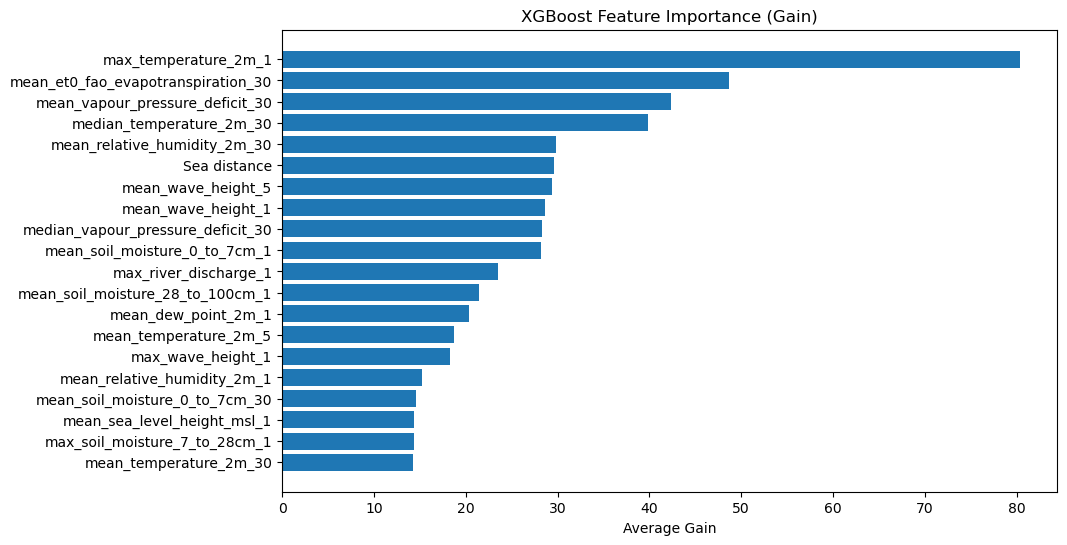

In [31]:
importance_df = pd.DataFrame({
    'feature': list(importance_gain_mapped.keys()),
    'gain': list(importance_gain_mapped.values())
}).sort_values('gain', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:20], importance_df['gain'][:20])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Average Gain')
plt.show()

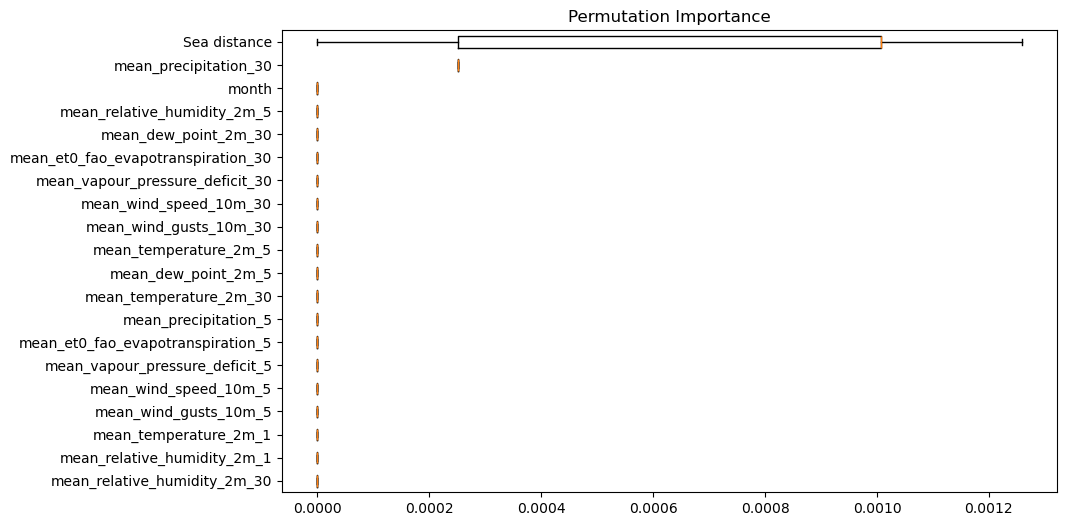

In [32]:

# Calculate permutation importance 
result = permutation_importance(
    model_XGBC_best_params,  
    X_test, 
    y_test,
    n_repeats=5,
    random_state=24,
    n_jobs=5
)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.boxplot(
    result.importances[sorted_idx[-20:]].T,  # Top 20 features
    vert=False,
    labels=X_test.columns[sorted_idx[-20:]]
)
plt.title("Permutation Importance")
plt.show()

In [33]:
# 1. Feature Importance (Gain) - Top 10 features
top_features = importance_df.head(10)  # Get the top 10 features
bar_x = top_features['gain']
bar_y = top_features['feature']

In [34]:
bar_y

43                  max_temperature_2m_1
23    mean_et0_fao_evapotranspiration_30
24       mean_vapour_pressure_deficit_30
11              median_temperature_2m_30
20          mean_relative_humidity_2m_30
5                           Sea distance
74                    mean_wave_height_5
75                    mean_wave_height_1
16     median_vapour_pressure_deficit_30
63         mean_soil_moisture_0_to_7cm_1
Name: feature, dtype: object

In [37]:
bar_y = [
    "Température maximale à 2m (1 jour)",
    "Évapotranspiration moyenne FAO ET0 (30 jours)",
    "Déficit moyen de pression de vapeur (30 jours)",
    "Température médiane à 2m (30 jours)",
    "Humidité relative moyenne à 2m (30 jours)",
    "Distance à la mer (fixe)",
    "Hauteur moyenne des vagues (5 jours)",
    "Hauteur moyenne des vagues (1 jour)",
    "Déficit médian de pression de vapeur (30 jours)",
    "Humidité moyenne du sol (0 à 7 cm, 1 jour)"
]

perm_features = X_test.columns[sorted_idx[-5:]]
perm_importances = result.importances[sorted_idx[-5:]]

fig = go.Figure()


fig.add_trace(
    go.Bar(
        x=bar_y,  
        y=bar_x,  
        orientation='v',  
        marker=dict(color='royalblue'),
        name="Importance des caractéristiques (Gain)"
    )
)


fig.update_layout(
    title="Analyse de l'importance des caractéristiques",
    height=800,
    width=1500,
    showlegend=False,
    xaxis=dict(title="Caractéristiques", showgrid=False),  
    yaxis=dict(title="Gain moyen", showgrid=False),  

)

fig.show()

In [36]:
joblib.dump(model_XGBC_best_params, 'output/model_XGBC_flood_type.pkl')

['output/model_XGBC_flood_type.pkl']

In [91]:
df_complete = pd.read_csv("../3 flood data analysis/output/complete_flood_data.csv")

In [92]:
df_complete.head()

,median_sea_level_height_msl_30,mean_sea_level_height_msl_30,mean_sea_level_height_msl_5,mean_sea_level_height_msl_1,max_sea_level_height_msl_1,lat,lon,Sea distance,Type,median_river_discharge_30,...,max_soil_moisture_100_to_255cm_1,elevation,median_wave_height_30,mean_wave_height_30,mean_wave_height_5,mean_wave_height_1,max_wave_height_1,month,Type_cd,is_flood
0,0.80470,0.802224,1.036652,0.958875,1.2597,41.324590,19.456469,5300.276600,River,0.383566,...,0.352,3.0,0.70,0.899865,1.667167,2.015833,3.14,11,2,1
1,0.81185,0.807646,0.982063,0.889192,1.1707,41.324590,19.456469,5300.276600,River,0.570363,...,0.360,3.0,0.74,0.923091,1.512000,1.275000,2.10,12,2,1
2,0.81370,0.813203,0.957242,0.940275,1.1667,41.324590,19.456469,5300.276600,River,0.625549,...,0.365,3.0,0.76,0.934274,1.224000,0.780833,1.22,12,2,1
3,0.82515,0.824850,0.991565,1.146608,1.4819,41.324590,19.456469,5300.276600,River,0.782379,...,0.368,3.0,0.78,0.961371,1.237667,1.142500,1.90,12,2,1
4,0.80470,0.802224,1.036652,0.958875,1.2597,41.786073,19.646076,11519.642694,River,0.428894,...,0.373,20.0,0.70,0.899865,1.667167,2.015833,3.14,11,2,1


In [93]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119794 entries, 0 to 119793
Data columns (total 83 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   median_sea_level_height_msl_30        119794 non-null  float64
 1   mean_sea_level_height_msl_30          119794 non-null  float64
 2   mean_sea_level_height_msl_5           119794 non-null  float64
 3   mean_sea_level_height_msl_1           119794 non-null  float64
 4   max_sea_level_height_msl_1            119794 non-null  float64
 5   lat                                   119794 non-null  float64
 6   lon                                   119794 non-null  float64
 7   Sea distance                          119794 non-null  float64
 8   Type                                  119794 non-null  object 
 9   median_river_discharge_30             119794 non-null  float64
 10  mean_river_discharge_30               119794 non-null  float64
 11  

In [ ]:
X = df_complete.drop(["lat", "lon", "Type", "Type_cd", "is_flood"], axis=1)
y = df_complete.loc[:,"is_flood"] # predict flood
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

In [99]:
X_train_resampled_ada, y_train_resampled_ada = adasyn.fit_resample(X_train, y_train)
X_train_resampled_ros, y_train_resampled_ros = ros.fit_resample(X_train, y_train)

In [ ]:
dataset_config = {
    "names": ["raw_data", "adasyn_oversampled", "random_oversampled"],
    "features": {
        "raw_data": X_train,
        "adasyn_oversampled": X_train_resampled_ada,
        "random_oversampled": X_train_resampled_ros
    },
    "labels": {
        "raw_data": y_train,
        "adasyn_oversampled": y_train_resampled_ada,
        "random_oversampled": y_train_resampled_ros
    }
}
# Removing SVC due to its poor performance and is excessively slow
model_config = {
    "classifier_names": [
        "logistic_regression", 
        "random_forest", 
        "xgboost_classifier"
    ],
    "initializers": {
        "logistic_regression": get_LG_model,
        "random_forest": get_RF_model,
        "xgboost_classifier": get_XGBC_model
    }
}


In [106]:
metrics_store = {}

for ds_name in dataset_config["names"]:
    metrics_store[ds_name] = {}
    X_data = dataset_config["features"][ds_name]
    y_data = dataset_config["labels"][ds_name]
    
    for model_name in model_config["classifier_names"]:
        print(f"\nEvaluating {model_name} on {ds_name}")
        
        classifier = model_config["initializers"][model_name]()
        
        start_time = time.time()
        classifier.fit(X_data, y_data)
        training_time = time.time() - start_time
        
        y_pred = classifier.predict(X_test)
        
        print(f"Train score: {classifier.score(X_train, y_train)}")
        metrics = evaluate_model(y_pred, y_test)
        
        metrics_store[ds_name][model_name] = {
            **metrics,
            "training_time": training_time
        }  


Evaluating logistic_regression on raw_data
Train score: 0.8908123336985444
Accuracy: 0.8945281522601111
Macro F1 Score: 0.7792438015316794
Micro F1 Score: 0.8945281522601111

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     19987
           1       0.77      0.52      0.62      3972

    accuracy                           0.89     23959
   macro avg       0.84      0.74      0.78     23959
weighted avg       0.89      0.89      0.89     23959

Confusion Matrix:
 [[19373   614]
 [ 1913  2059]]

Evaluating random_forest on raw_data
Train score: 1.0
Accuracy: 0.9826787428523728
Macro F1 Score: 0.9674289301081865
Micro F1 Score: 0.9826787428523728

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     19987
           1       0.99      0.90      0.95      3972

    accuracy                           0.98     23959
   macro avg       0.99   

In [ ]:
metrics_data = []
for dataset_name, model_data in metrics_store.items():
    for model_name, metrics in model_data.items():
        metrics_data.append({
            'Model': model_name.replace("_", " "),
            'Dataset': dataset_name.replace("_", " "),
            'Accuracy': metrics['accuracy'],
            'F1 Macro': metrics['f1_macro'],
            'F1 Micro': metrics['f1_micro'],
            'Training Time': metrics['training_time']
        })

df = pd.DataFrame(metrics_data)

fig_perf = px.bar(
    df.melt(id_vars=['Model', 'Dataset'], 
            value_vars=['Accuracy', 'F1 Macro', 'F1 Micro'],
            var_name='Metric'),
    x='Model', y='value', color='Dataset',
    facet_col='Metric', barmode='group',
    title='Model Performance Metrics',
    labels={'value': 'Score'}
)

fig_time = px.bar(
    df, x='Model', y='Training Time', color='Dataset',
    title='Model Training Times',
    labels={'Training Time': 'Seconds'},
    barmode='group'
)

fig_perf.show()
fig_time.show() 

In [138]:
search_spaces = {
    'n_estimators': Integer(50, 500),  
    'max_depth': Categorical([None] + list(range(3, 21))),  
    'min_samples_split': Integer(2, 20), 
    'min_samples_leaf': Integer(1, 10),  
    'max_features': Categorical(['sqrt', 'log2', 0.3, 0.5, 0.7]),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy'])
}

bayes_search_RF = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=24),
    search_spaces=search_spaces,
    n_iter=5,  
    cv=3,
    n_jobs=5,
    scoring="f1_macro",
    random_state=24
)

model_bayes_RF = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("Classifier", bayes_search_RF)
])

model_bayes_RF.fit(X_train_resampled_ros, y_train_resampled_ros)

y_pred = model_bayes_RF.predict(X_test)
print(f"Train score: {model_bayes_RF.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)
print(bayes_search_RF.best_params_)

Train score: 0.9943944797189357
Accuracy: 0.9860177803748069
Macro F1 Score: 0.9745989469607856
Micro F1 Score: 0.9860177803748069

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     19987
           1       0.96      0.95      0.96      3972

    accuracy                           0.99     23959
   macro avg       0.98      0.97      0.97     23959
weighted avg       0.99      0.99      0.99     23959

Confusion Matrix:
 [[19844   143]
 [  192  3780]]
OrderedDict({'bootstrap': True, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.3, 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 381})


In [ ]:
search_spaces = {
    'n_estimators': Integer(100, 500),  
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),  
    'max_depth': Integer(3, 8),  
    'gamma': Real(0.0, 0.5),  
    'colsample_bytree': Real(0.6, 1.0),  
    'subsample': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

bayes_search_XGBC_2 = BayesSearchCV(
    estimator=XGBClassifier(random_state=24),
    search_spaces=search_spaces,
    n_iter=5, 
    cv=3,
    n_jobs=5,
    scoring='f1_macro',
    random_state=24
)
model_bayes_XGBC_2 = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ("Classifier",bayes_search_XGBC_2)
])
model_bayes_XGBC_2.fit(X_train, y_train)

y_pred = model_bayes_XGBC_2.predict(X_test)
print(f"Train score: {model_bayes_XGBC_2.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)
print(bayes_search_XGBC_2.best_params_)

Train score: 1.0
Accuracy: 0.994824491840227
Macro F1 Score: 0.9905448533522896
Micro F1 Score: 0.994824491840227

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     19987
           1       1.00      0.97      0.98      3972

    accuracy                           0.99     23959
   macro avg       1.00      0.99      0.99     23959
weighted avg       0.99      0.99      0.99     23959

Confusion Matrix:
 [[19977    10]
 [  114  3858]]
OrderedDict({'colsample_bytree': 0.7014101893279452, 'gamma': 0.0020657631919344115, 'learning_rate': 0.10055436132294916, 'max_depth': 8, 'n_estimators': 447, 'reg_alpha': 0.7487104995781331, 'reg_lambda': 0.9360007063056492, 'subsample': 0.9548051491131722})


In [139]:
search_spaces = {
    'n_estimators': Integer(100, 500),  
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),  
    'max_depth': Integer(3, 8),  
    'gamma': Real(0.0, 0.5),  
    'colsample_bytree': Real(0.6, 1.0),  
    'subsample': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

bayes_search_XGBC_3 = BayesSearchCV(
    estimator=XGBClassifier(random_state=24),
    search_spaces=search_spaces,
    n_iter=5, 
    cv=3,
    n_jobs=5,
    scoring='f1_macro',
    random_state=24
)
model_bayes_XGBC_3 = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ("Classifier",bayes_search_XGBC_3)
])
model_bayes_XGBC_3.fit(X_train_resampled_ros, y_train_resampled_ros)

y_pred = model_bayes_XGBC_3.predict(X_test)
# Print Scores 
print(f"Train score: {model_bayes_XGBC_3.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)
print(bayes_search_XGBC_3.best_params_)

Train score: 1.0
Accuracy: 0.995700989189866
Macro F1 Score: 0.9921757962465774
Micro F1 Score: 0.995700989189866

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19987
           1       1.00      0.98      0.99      3972

    accuracy                           1.00     23959
   macro avg       1.00      0.99      0.99     23959
weighted avg       1.00      1.00      1.00     23959

Confusion Matrix:
 [[19969    18]
 [   85  3887]]
OrderedDict({'colsample_bytree': 0.7014101893279452, 'gamma': 0.0020657631919344115, 'learning_rate': 0.10055436132294916, 'max_depth': 8, 'n_estimators': 447, 'reg_alpha': 0.7487104995781331, 'reg_lambda': 0.9360007063056492, 'subsample': 0.9548051491131722})


In [ ]:
search_spaces = {
    'n_estimators': Integer(100, 500),  
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),  
    'max_depth': Integer(3, 8),  
    'gamma': Real(0.0, 0.5),  
    'colsample_bytree': Real(0.6, 1.0),  
    'subsample': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

bayes_search_XGBC_3 = BayesSearchCV(
    estimator=XGBClassifier(random_state=24),
    search_spaces=search_spaces,
    n_iter=100, 
    cv=3,
    n_jobs=5,
    scoring='neg_brier_score',
    random_state=24
)
model_bayes_XGBC_3 = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ("Classifier",bayes_search_XGBC_3)
])
model_bayes_XGBC_3.fit(X_train_resampled_ros, y_train_resampled_ros)

y_pred = model_bayes_XGBC_3.predict(X_test)
print(f"Train score: {model_bayes_XGBC_3.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)
print(bayes_search_XGBC_3.best_params_)

Train score: -6.779782903658843e-07
Accuracy: 0.9964105346633833
Macro F1 Score: 0.9934704984747424
Micro F1 Score: 0.9964105346633833

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19987
           1       1.00      0.98      0.99      3972

    accuracy                           1.00     23959
   macro avg       1.00      0.99      0.99     23959
weighted avg       1.00      1.00      1.00     23959

Confusion Matrix:
 [[19975    12]
 [   74  3898]]
OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.22688747947345916, 'max_depth': 8, 'n_estimators': 407, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0})


In [142]:
search_spaces = {
    'calibrator__estimator__n_estimators': Integer(100, 500),
    'calibrator__estimator__learning_rate': Real(1e-3, 0.3, prior='log-uniform'),
    'calibrator__estimator__max_depth': Integer(3, 8),
    'calibrator__estimator__gamma': Real(0.0, 0.5),
    'calibrator__estimator__colsample_bytree': Real(0.6, 1.0),
    'calibrator__estimator__subsample': Real(0.6, 1.0),
    'calibrator__estimator__reg_alpha': Real(0.0, 1.0),
    'calibrator__estimator__reg_lambda': Real(0.0, 1.0),
    'calibrator__method': Categorical(['sigmoid', 'isotonic'])
}

pipeline = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ('calibrator', CalibratedClassifierCV(
        estimator=XGBClassifier(random_state=24),
        cv=3  
    ))
])

bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=100,
    cv=3,
    n_jobs=5,
    scoring='neg_brier_score',
    random_state=24
)

bayes_search.fit(X_train_resampled_ros, y_train_resampled_ros)

y_pred = bayes_search.predict(X_test)
print(f"Train score: {bayes_search.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)
print(bayes_search.best_params_)

Train score: -4.16461699558053e-05
Accuracy: 0.990024625401728
Macro F1 Score: 0.9815305392570364
Micro F1 Score: 0.990024625401728

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     19987
           1       1.00      0.94      0.97      3972

    accuracy                           0.99     23959
   macro avg       0.99      0.97      0.98     23959
weighted avg       0.99      0.99      0.99     23959

Confusion Matrix:
 [[19984     3]
 [  236  3736]]
OrderedDict({'calibrator__estimator__colsample_bytree': 1.0, 'calibrator__estimator__gamma': 0.0, 'calibrator__estimator__learning_rate': 0.3, 'calibrator__estimator__max_depth': 8, 'calibrator__estimator__n_estimators': 450, 'calibrator__estimator__reg_alpha': 0.0, 'calibrator__estimator__reg_lambda': 0.5451599017129555, 'calibrator__estimator__subsample': 1.0, 'calibrator__method': 'isotonic'})


In [148]:
bestmodel_calibrated_XGBC = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ('calibrator', CalibratedClassifierCV(
        estimator=XGBClassifier(**bayes_search_XGBC_3.best_params_),
        cv=3,
        method="isotonic"
    ))
])

bestmodel_calibrated_XGBC.fit(X_train_resampled_ros, y_train_resampled_ros)
y_pred = bestmodel_calibrated_XGBC.predict(X_test)
print(f"Train score: {bestmodel_calibrated_XGBC.score(X_train, y_train)}")
evaluate_model(y_pred, y_test, False)

Train score: 1.0
Accuracy: 0.9908593847823365
Macro F1 Score: 0.9831150095427811
Micro F1 Score: 0.9908593847823365

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     19987
           1       1.00      0.95      0.97      3972

    accuracy                           0.99     23959
   macro avg       0.99      0.97      0.98     23959
weighted avg       0.99      0.99      0.99     23959

Confusion Matrix:
 [[19983     4]
 [  215  3757]]


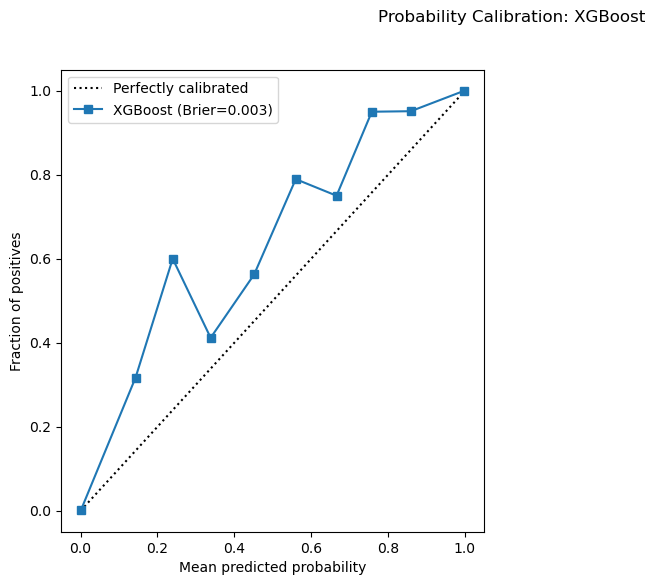

brier score 0.002922775998140172
log loss 0.011802703210718319
roc auc 0.9996356770873878
pr auc 0.9988404582809471


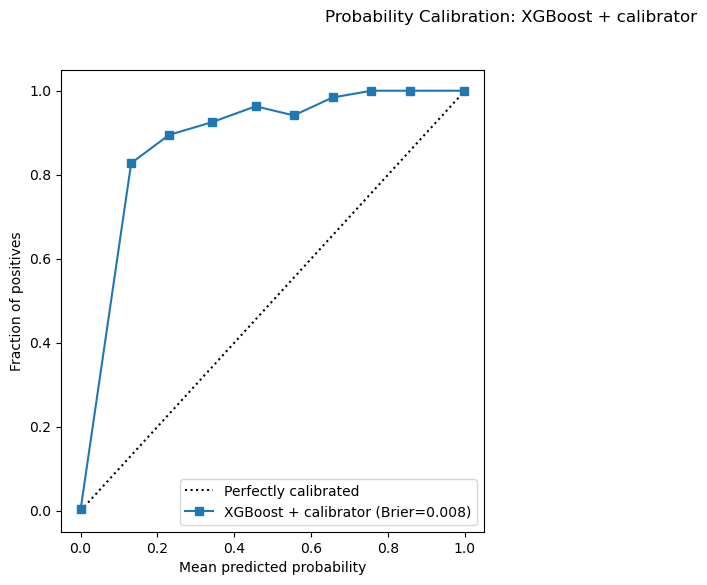

brier score 0.0077160161240967615
log loss 0.03273598055188643
roc auc 0.9992836229752763
pr auc 0.9976024679650235


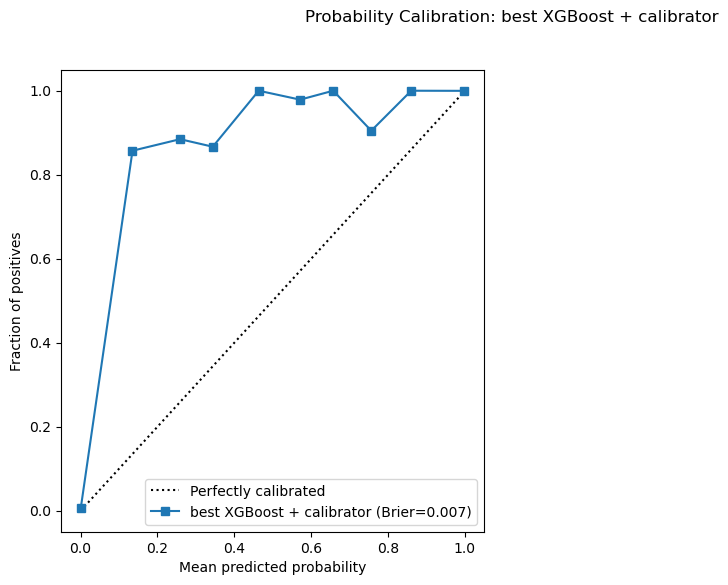

brier score 0.0074880215569494485
log loss 0.0346369786107424
roc auc 0.9991166841528565
pr auc 0.9967958086813626


In [ ]:
def evaluate_proba(y_true, y_proba, n_bins=10, model_name=""):
    # Evaluate probability quality with metrics and plots.
    
    # Calculate metrics
    brier = brier_score_loss(y_true, y_proba)
    logloss = log_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    
    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins)
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Reliability diagram
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred, prob_true, "s-", label=f"{model_name} (Brier={brier:.3f})")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    
    plt.suptitle(f"Probability Calibration: {model_name}")
    plt.show()
    
    print("brier score", brier)
    print("log loss", logloss)
    print("roc auc", roc_auc)
    print("pr auc", pr_auc)


y_proba = model_bayes_XGBC_3.predict_proba(X_test)[:, 1]  
evaluate_proba(y_test, y_proba, model_name="XGBoost")
y_proba = bayes_search.predict_proba(X_test)[:, 1]  
evaluate_proba(y_test, y_proba, model_name="XGBoost + calibrator")
y_proba = bestmodel_calibrated_XGBC.predict_proba(X_test)[:, 1]  
evaluate_proba(y_test, y_proba, model_name="best XGBoost + calibrator")

In [216]:
y_pred = (model_bayes_XGBC_3.predict_proba(X_test)[:, 1]  >= 0.1).astype(int)
evaluate_model(y_pred, y_test, False)

Accuracy: 0.9959096790350181
Macro F1 Score: 0.992629790879825
Micro F1 Score: 0.9959096790350181

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19987
           1       0.98      0.99      0.99      3972

    accuracy                           1.00     23959
   macro avg       0.99      0.99      0.99     23959
weighted avg       1.00      1.00      1.00     23959

Confusion Matrix:
 [[19922    65]
 [   33  3939]]


Train score: 1.0
Accuracy: 1.0
Macro F1 Score: 1.0
Micro F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     99934
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    119794
   macro avg       1.00      1.00      1.00    119794
weighted avg       1.00      1.00      1.00    119794

Confusion Matrix:
 [[99934     0]
 [    0 19860]]


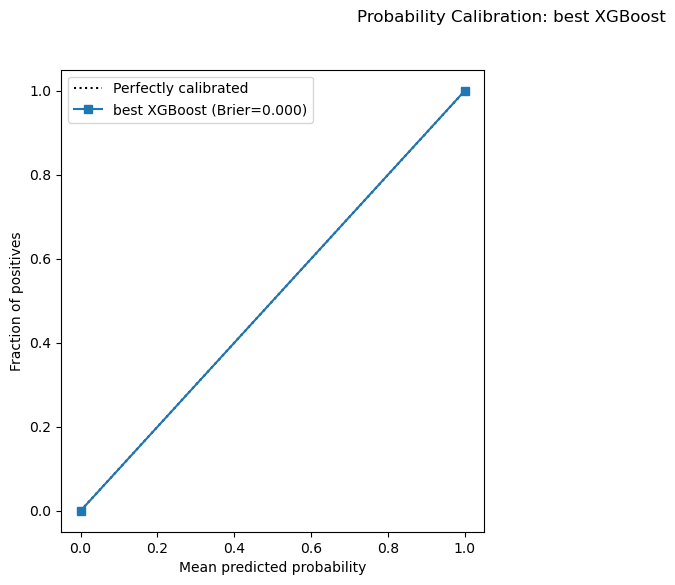

brier score 6.510566176626954e-07
log loss 0.00024534218865031614
roc auc 1.0
pr auc 1.0


In [206]:

final_model_XGBC_best_params = Pipeline(steps=[
    ("standard_scaler", StandardScaler()),
    ("Classifier", XGBClassifier(**bayes_search_XGBC_3.best_params_))
])
X_resampled_ros, y_resampled_ros = ros.fit_resample(X, y)
final_model_XGBC_best_params.fit(X_resampled_ros, y_resampled_ros)

y_pred = final_model_XGBC_best_params.predict(X)

print(f"Train score: {final_model_XGBC_best_params.score(X, y)}")
evaluate_model(y_pred,y)
y_proba = final_model_XGBC_best_params.predict_proba(X)[:, 1]  
evaluate_proba(y, y_proba, model_name="best XGBoost")

In [210]:
f1_score((y_proba  >= 0.1).astype(int), y)

1.0

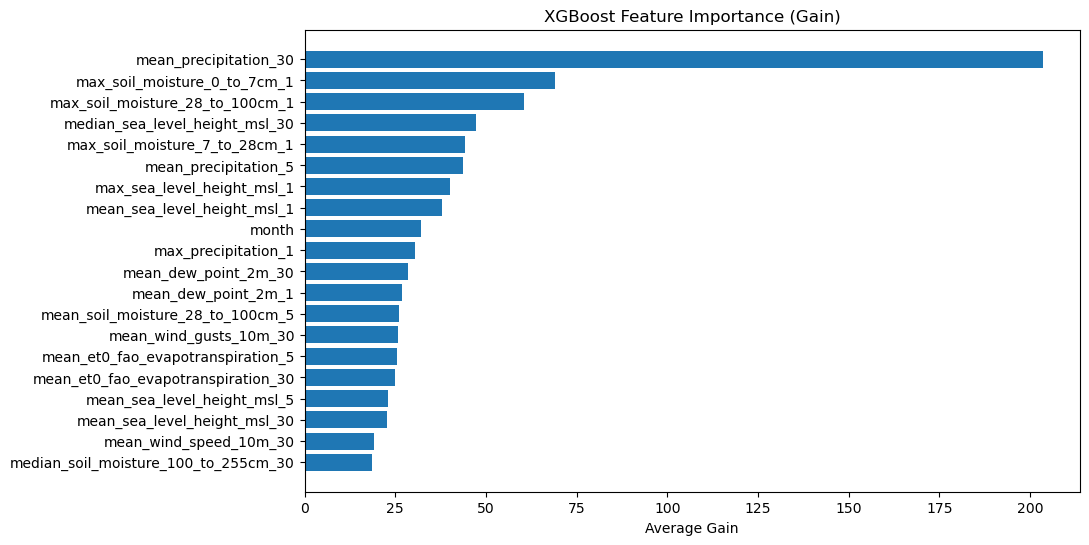

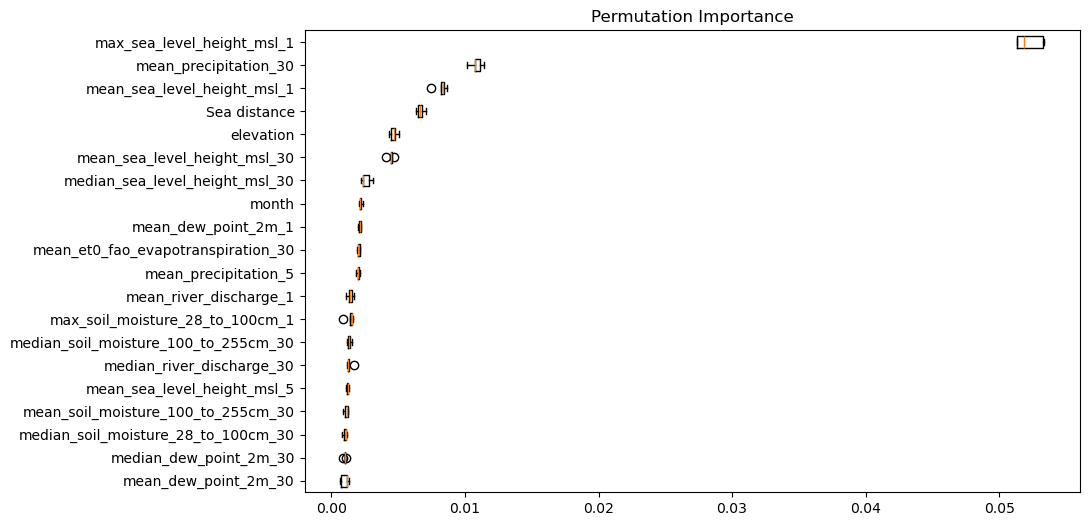

In [211]:
feature_names = X.columns.tolist() 
feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}
xgb_model = final_model_XGBC_best_params.named_steps['Classifier']
importance_weights = xgb_model.feature_importances_
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_cover = xgb_model.get_booster().get_score(importance_type='cover')

importance_gain_mapped = {
    feature_map[key]: value 
    for key, value in importance_gain.items()
    if key in feature_map
}

importance_df = pd.DataFrame({
    'feature': list(importance_gain_mapped.keys()),
    'gain': list(importance_gain_mapped.values())
}).sort_values('gain', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:20], importance_df['gain'][:20])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Average Gain')
plt.show()


result = permutation_importance(
    model_XGBC_best_params,  
    X_test, 
    y_test,
    n_repeats=5,
    random_state=24,
    n_jobs=5
)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.boxplot(
    result.importances[sorted_idx[-20:]].T,  # Top 20 features
    vert=False,
    labels=X_test.columns[sorted_idx[-20:]]
)
plt.title("Permutation Importance")
plt.show()

In [212]:
# 1. Feature Importance (Gain) - Top 10 features
top_features = importance_df.head(10)  # Get the top 10 features
bar_x = top_features['gain']
bar_y = top_features['feature']

In [213]:
bar_y

21              mean_precipitation_30
66       max_soil_moisture_0_to_7cm_1
68    max_soil_moisture_28_to_100cm_1
0      median_sea_level_height_msl_30
67      max_soil_moisture_7_to_28cm_1
29               mean_precipitation_5
4          max_sea_level_height_msl_1
3         mean_sea_level_height_msl_1
76                              month
45                max_precipitation_1
Name: feature, dtype: object

In [214]:
bar_y = [
    "Précipitation moyenne (30 jours)",
    "Humidité maximale du sol (0 à 7 cm, 1 jour)",
    "Humidité maximale du sol (28 à 100 cm, 1 jour)",
    "Hauteur médiane du niveau de la mer (30 jours)",
    "Humidité maximale du sol (7 à 28 cm, 1 jour)",
    "Précipitation moyenne (5 jours)",
    "Hauteur maximale du niveau de la mer (1 jour)",
    "Hauteur moyenne du niveau de la mer (1 jour)",
    "Mois",
    "Précipitation maximale (1 jour)"
]

perm_features = X_test.columns[sorted_idx[-5:]]
perm_importances = result.importances[sorted_idx[-5:]]

fig = go.Figure()


fig.add_trace(
    go.Bar(
        x=bar_y,  
        y=bar_x,  
        orientation='v',  
        marker=dict(color='royalblue'),
        name="Importance des caractéristiques (Gain)"
    )
)


fig.update_layout(
    title="Analyse de l'importance des caractéristiques",
    height=800,
    width=1500,
    showlegend=False,
    xaxis=dict(title="Caractéristiques", showgrid=False),  
    yaxis=dict(title="Gain moyen", showgrid=False),  

)

fig.show()

In [215]:
joblib.dump(final_model_XGBC_best_params, 'output/model_XGBC_predict_flood.pkl')

['output/model_XGBC_predict_flood.pkl']